# Quantum feature maps and kernels

In this second part of the course, we'll explore quantum feature maps and kernels in the context of machine learning classification problems.

## Introduction

The general task of machine learning is to find and study patterns in data. Many machine learning algorithms <u>map their input dataset to a higher dimensional feature space</u>, through the use of a ```kernel function```:

$$
k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle
$$

where $k$ is the kernel function, $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs, $f$ is a map from $n$-dimension to $m$-dimension space (usually $m >> n$), and $\langle a,b \rangle$ denotes the dot product. 

**But what does this mean??**

Well, let us first go back to the definition of a classification problem:

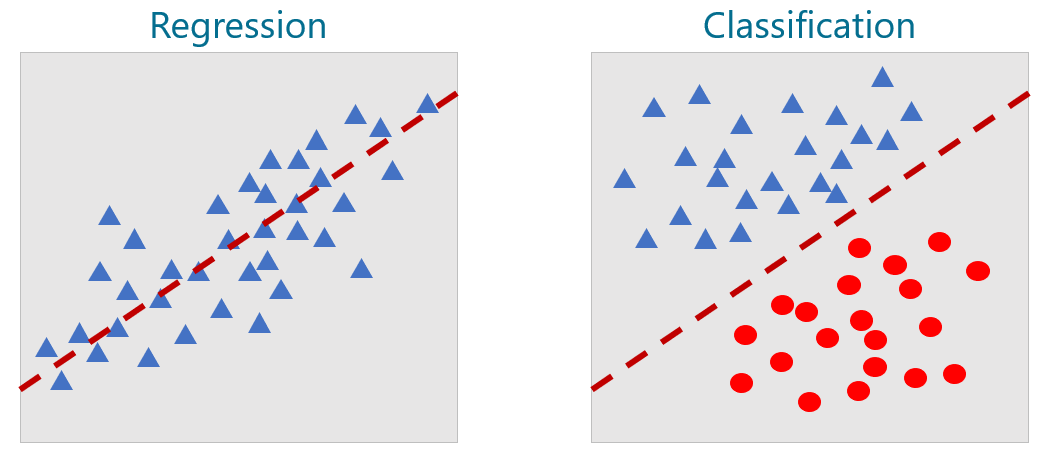

In the classification problem above, the two classes were linearly separable, that means we can draw a line that separates examples for each class with no error.

However, this is not always the case:

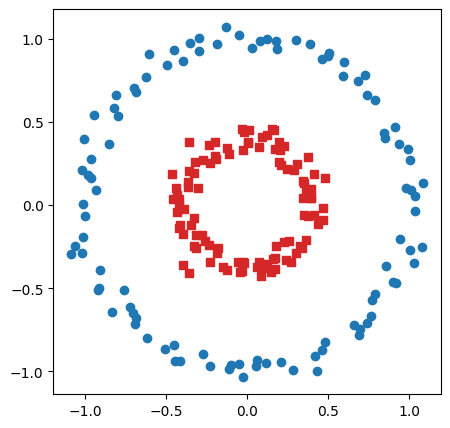

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles

# Create circles dataset
X, Y = make_circles(n_samples=200, noise=0.05, factor=0.4)

# Separate smaller and larger circles
A = X[np.where(Y==0)]
B = X[np.where(Y==1)]

# Plot in 2D
plt.figure(figsize=(5,5))
plt.scatter(A[:,0],A[:,1], marker='o')
plt.scatter(B[:,0],B[:,1], marker='s', c='C3')
plt.show()

In the above example, there is no possibility to draw a line that separates the two classes without assuming certain error in the classification.

We can do two things (if giving up is not consider one):

-Use some sort of more sophisticated machine learning method that is able to do better than coming up with "linear decision boundaries" (e.g. multi-layer neural network) or ...

-Try to find a mapping for projecting the input space into an alternative feature space where the problem becomes linearly separable

Let's demonstrate the concept of mapping a dataset to a higher dimensional feature space, with the above [circles dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), which contains a large circle containing a smaller circle in two dimensions:

What if we map the original 2-D space above to three dimensions by applying the following $z = x^2 + y^2$ transformation?

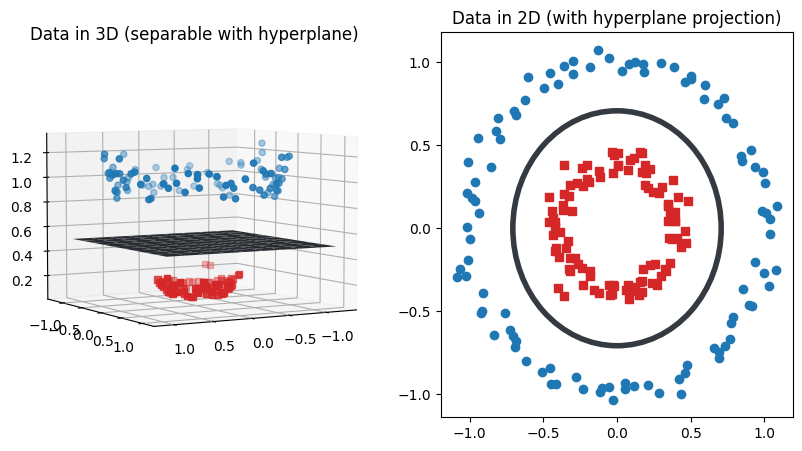

In [2]:
def transform_function(x, y):
    """ Implements f(x,y) = [x, y, z = x^2 + y^2] """
    # pylint: disable=invalid-name
    return np.array([x, y, x**2.0 + y**2.0])

# Transform
A1 = np.array([transform_function(x, y) for
               x, y in zip(np.ravel(A[:,0]), np.ravel(A[:,1]))])
B1 = np.array([transform_function(x, y)
               for x, y in zip(np.ravel(B[:,0]), np.ravel(B[:,1]))])

# Plot in 3D
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Data in 3D (separable with hyperplane)")
ax.scatter(A1[:,0], A1[:,1], A1[:,2], marker='o')
ax.scatter(B1[:,0], B1[:,1], B1[:,2], marker='s', c='C3')  # make red
ax.view_init(5, 60)
x = np.arange(-1.25, 1.25, 0.25)
y = np.arange(-1.25, 1.25, 0.26)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z[:,:] = 0.5
ax.plot_surface(X, Y, Z, color='#343A3F')

# Project data to 2D
ax2d = fig.add_subplot(122)
ax2d.set_title("Data in 2D (with hyperplane projection)")
ax2d.scatter(A1[:,0], A1[:,1], marker='o')
ax2d.scatter(B1[:,0], B1[:,1], marker='s',
            c='C3')  # make red
ax2d.add_patch(pl.Circle((0,0), radius=np.sqrt(0.5),
               fill=False, linestyle='solid', linewidth=4.0,
               color='#343A3F'))
plt.show()

As we can see above, in three dimensions, the data is separable by a ```hyperplane``` at $z = 0.5$, which leds to a non-linear decision boundary (a circumference, in this case) if we project the data back to the original two dimensions

<span style="color:red">PRACTICE:</span> change parameter z to have a sense of the resulting decision boundary projection.

All right, would you say, but...

(1). Does the mapping in the example above just work for any possible dataset? How do we find the appropiate mapping on each case?

(2). And what is the relation between the feature mapping and the kernel function? Why do we want a kernel function at all?

(3) And last but not least...where *the quantum* component is in all this? 

...introducing **quantum feature maps**!

## Quantum feature maps

In quantum machine learning, a quantum feature map, $\phi(\vec{x})$, maps a classical feature vector, $\vec{x}$, to a quantum Hilbert space, $| \Phi(\vec{x})\rangle \langle \Phi(\vec{x})|$. We can obtain $\vec{x} \rightarrow | \Phi(\vec{x})\rangle$ using a unitary transformation $\vec{U_\Phi}(\vec{x})$, which is typically a [parameterized quantum circuit](https://learn.qiskit.org/course/machine-learning/parameterized-quantum-circuits).

Constructing quantum feature maps based on parameterized quantum circuits <u>that are hard to simulate classically</u> is an important step towards possibly obtaining an advantage over classical machine learning approaches, and is an active area of current research.

In *Reference 1*, the authors propose a family of quantum feature maps that are conjectured to be hard to simulate classically, and can be implemented as short-depth circuits (i.e. composed of few layers of gates) on near-term quantum devices (noisy quantum hardware available in the neear future)). Qiskit implements these as the [PauliFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html). The quantum feature map of depth $d$ is implemented by the unitary operator:

$$ \mathcal{U}_{\Phi(\vec{x})}=\prod_d U_{\Phi(\vec{x})}H^{\otimes n},$$

with $$\ U_{\Phi(\vec{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\vec{x})\prod_{k\in S} P_i\right)$$

which contains layers of Hadamard gates interleaved with entangling blocks (e.g. using CNOT gates), $U_{\Phi(\vec{x})}$, encoding the classical data as shown in circuit diagram below for $d=2$.

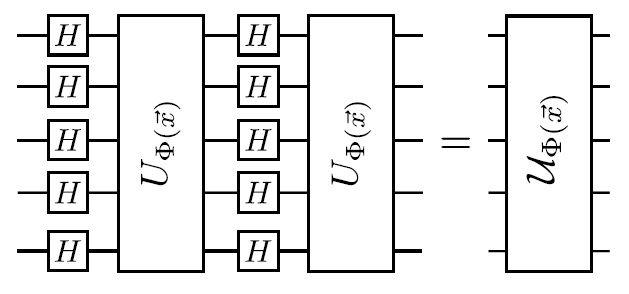

_*Be careful with the notation, as it might be a bit confusing, in particular to distinguish between $\mathcal{U}_{\Phi(\vec{x})}$ and $U_{\Phi(\vec{x})}$, and between $\phi(\vec{x})$ and $\Phi(\vec{x})$_

Within the entangling blocks, $U_{\Phi(\vec{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivity between different qubits or data points: $S \in \{\binom{n}{k}\ \mathrm{combinations,\ }k = 1,... n \}$, and by default the data mapping function $\phi_S(\vec{x})$ is

$$\phi_S:\vec{x}\mapsto \Bigg\{
    \begin{array}{ll}
        x_i & if\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & if\ S=\{i,j\}
    \end{array}$$

when $k = 1$, $P_0 = Z, this is the [ZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html) in Qiskit:

$$\mathcal{U}_{\Phi(\vec{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\vec{x}) \, Z_j\right) \, H^{\otimes n} \right)^d$$

which is defined as:

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


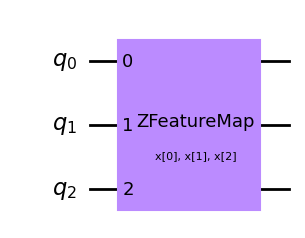

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


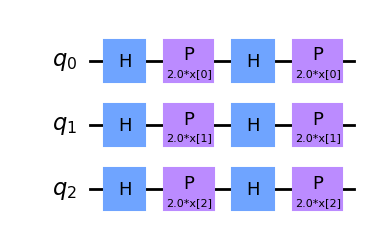

In [3]:
from qiskit.circuit.library import ZFeatureMap
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)

display(map_z.draw("mpl"))

display(map_z.decompose().draw("mpl"))

# Check: we see no interactions between the different lines (qubits). There is not entanglement 
# -> this feature map is "simple" to simulate classically

when $k = 2$ (i.e. combinations in groups of 2), $P_0 = Z, P_1 = ZZ$, this is the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) in Qiskit:

$$\mathcal{U}_{\Phi(\vec{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\vec{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\vec{x}) \, Z_j\right) \, H^{\otimes n} \right)^d$$

In [4]:
from qiskit.circuit.library import ZZFeatureMap
# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)

display(map_zz.draw("mpl"))

display(map_zz.decompose().draw("mpl"))

display(map_zz.decompose().decompose().draw("mpl")) # And of course might "transpile" differently depending on end-point backend

Let's have a look at the [`adhoc`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html) dataset in Qiskit, which is a two class dataset sampled from the `ZZFeatureMap` used in *Reference 1*, creating 20 training data points and 5 testing data points of 2 features from each class:

In [ ]:
#from qiskit.utils import algorithm_globals
from qiskit_algorithms.utils import algorithm_globals # Recommended as of qiskit-algorithms 0.20 (24-Aug-2023)
algorithm_globals.random_seed = 12345

n_features = 2 # The current implementation of "ad_hoc" dataset only works with n = 2 or 3 (see documentation)
from qiskit_machine_learning.datasets import ad_hoc_data
train_data, train_labels, test_data, test_labels, sample_total = (
    ad_hoc_data(training_size=20, test_size=5, n=n_features, gap=0.3,
                include_sample_total=True, one_hot=False))

In [ ]:
# Plot data and class boundaries
fig = plt.figure(figsize=(15, 5))
axdata = fig.add_subplot(131)
axdata.set_title("Data")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)
plt.scatter(train_data[np.where(train_labels[:] == 0), 0],
            train_data[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='C0',
            label="A train")
plt.scatter(train_data[np.where(train_labels[:] == 1), 0],
            train_data[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='C3',
            label="B train")
plt.scatter(test_data[np.where(test_labels[:] == 0), 0],
            test_data[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='C0', label="A test")
plt.scatter(test_data[np.where(test_labels[:] == 1), 0],
            test_data[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='C3', label="B test")
plt.legend()

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["C3","w","C0"])
axmap = fig.add_subplot(132)
axmap.set_title("Class Boundaries")
axmap.set_ylim(0, 2 * np.pi)
axmap.set_xlim(0, 2 * np.pi)
axmap.imshow(np.asmatrix(sample_total).T,
             interpolation='nearest',
             origin='lower', cmap=cmap,
             extent=[0, 2 * np.pi, 0, 2 * np.pi])

axboth = fig.add_subplot(133)
axboth.set_title("Data overlaid on Class Boundaries")
axboth.set_ylim(0, 2 * np.pi)
axboth.set_xlim(0, 2 * np.pi)
axboth.imshow(np.asmatrix(sample_total).T, interpolation='nearest',
              origin='lower', cmap=cmap,
              extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth.scatter(train_data[np.where(train_labels[:] == 0), 0],
               train_data[np.where(train_labels[:] == 0), 1],
               marker='s', facecolors='w', edgecolors='C0', label="A")
axboth.scatter(train_data[np.where(train_labels[:] == 1), 0],
               train_data[np.where(train_labels[:] == 1), 1],
               marker='o', facecolors='w', edgecolors='C3', label="B")
axboth.scatter(test_data[np.where(test_labels[:] == 0), 0],
               test_data[np.where(test_labels[:] == 0), 1],
               marker='s', facecolors='C0', edgecolors='w',
               label="A test")
axboth.scatter(test_data[np.where(test_labels[:] == 1), 0],
               test_data[np.where(test_labels[:] == 1), 1],
               marker='o', facecolors='C3', edgecolors='w',
               label="B test")
plt.show()

On the left plot above, we see 25 two-dimensional data points (hence, including both training and test samples) from each class in `adhoc` dataset, noting that there is no obvious pattern as to which class each data point belongs to. In the middle plot above, the corresponding two-dimensional projection of the sixteen-dimensional (fifteen in reality) feature space described by the `ZZFeatureMap` used to create the dataset is shown, highlighting the complexity of the underlying class boundaries in two dimensions. On the right, we see the data points overlaid on the same two-dimensional class boundaries.

It turns out <u>this mapping is difficult to simulate classically!</u>

## (Quantum) kernels

Very briefly (we will go through that in more detail later) in the context of kernel methods in machine learning, we are interested in using a **kernel function as a means of <u>efficiently</u> calculating the result of an operation in the induced feature space without having to explicitly operate in that space**. This is referred as the ```kernel trick```.

Recall, we usually aim to operate in feature space of much higher dimension that the original input space, which consequently migh become very computationally expensive, or even impossible at all (induced feature spaces could be infinite-dimensional!). 

This applies to <u>both classical and quantum induced feature spaces</u>, whereby a (quantum) feature map, $\phi(\vec{x})$, naturally gives rise to a (quantum) kernel, $k(\vec{x}_i,\vec{x}_j)= \phi(\vec{x}_j)^\dagger\phi(\vec{x}_i)$, which we can think of as a measure of similarity: $k(\vec{x}_i,\vec{x}_j)$ is large when $\vec{x}_i$ and $\vec{x}_j$ are close in the induced feature space.

That being said, focusing in the quantum realm, we can calculate $k(\vec{x}_i,\vec{x}_j)$ on a quantum computer as the transition amplitude:

$$
k(\vec{x}_i,\vec{x}_j) =
\left| \langle \Phi^\dagger(\vec{x}_j)| \Phi(\vec{x}_i) \rangle \right|^{2} =
\left| \langle 0^{\otimes n} | U^\dagger_{\Phi(\vec{x}_j)} U^{}_{\Phi(\vec{x}_i)} | 0^{\otimes n} \rangle \right|^{2}
$$

assuming the feature map is represented through a [parameterized quantum circuit](./parameterized-quantum-circuits) (allowing encoding of our classical inputs $\vec{x}$), which can be described as a unitary transformation $U_\Phi(\vec{x})$ on $n$ qubits.

Notice the above operation corresponds to calculation of the ```the fidelity``` (similarity or _overlap_) between the two corresponding induced quantum states.

The result of this operation can be finally used in a kernel-based machine learning algorithm, such as support vector classification.

## The main takeaway idea: 

We hope for this sort of quantum feature maps to generate interesting mappings from inputs to feature space (that are not possible or very hard to be generated classically) where we can take (quantum) advantage, either by means of classical, quantum, or hybrid machine learning methods. In the case of classification, for instance, we aim to achieve better decision boundaries to outperform the behaviour of purely classical approaches.

One such possibility is to leverage quantum feature maps in the form of ```quantum kernels``` to perform the ```kernel trick``` in the context of the so-called *kernel methods* in machine learning. The well known support vector machine (SVM) classification algorithm is possibly the best (extended) example of using this approach, but kernel methods also find application in other areas such as clustering, or dimensionality reduction.

All right, but this might be a bit of too much information all at once. Let us go back to the basics, and build up step by step from there. This is the roadmap:

1. Linear methods for classical machine learning

2. Linear SVM's

3. Non-linear SVM's

4. Using quantum feature maps for implementing quantum kernels

5. Classical PCA

6. (Quantum) Kernel PCA

## References

1. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1804.11326](https://arxiv.org/abs/1804.11326)

2. https://learn.qiskit.org/course/machine-learning/quantum-feature-maps-kernels
   
3. Maria Schuld and Nathan Killoran, *Quantum machine learning in feature Hilbert spaces*, Physical Review Letters 122, 040504 (2019), [doi.org:10.1103/PhysRevLett.122.040504](https://doi.org/10.1103/PhysRevLett.122.040504), [arXiv:1803.07128](https://arxiv.org/abs/1803.07128)